In [1]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [2]:
!pip install transformers

In [3]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer
from transformers import AlbertModel, PreTrainedTokenizerFast
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [4]:
print(torch.__version__)

2.5.1+cu121


In [7]:
# Load the data
df = pd.read_csv('/content/drive/MyDrive/NLP Project/Dataset/Processed Data.csv')

In [8]:
df.head()

,label,text
0,1,কারণ আমরা একলাফে চাকরি পাওয়ার সপ্ন দেখি ছোটখাট...
1,0,"অরন্যদেব ছবিতে যে ছিল আমার কন্যা , সে আজ থেকে ..."
2,1,ঢাকার কষ্টের আরেক নাম ব্যাচেলর জীবন
3,0,ইয়াশ রোহানতটিনী সেরা জুটিতটিনীকে আমার অনেক ভাল...
4,1,জনগণের ভোট চুরি করে ক্ষমতায় আসা ওই নিয়ত আমাদ...


In [9]:
print(df.info())

label_counts = df['label'].value_counts()
print("Label Details:")
print(label_counts)

df.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9376 entries, 0 to 9375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9376 non-null   int64 
 1   text    9376 non-null   object
dtypes: int64(1), object(1)
memory usage: 146.6+ KB
None
Label Details:
label
1    4721
0    4655
Name: count, dtype: int64


,label,text
333,0,প্রিয় অধরা যদি আমার কোনো ভুল হয় । অন্যের কাছ...
6451,0,আলহামদুলিল্লাহ একটি টিকাও নেইনি কোন প্রবলেম হয...
1215,0,এতোদিন দেয়না কেন
720,1,"বালিকা , যতই জিন্স আর টি শার্ট পড়ো না কেন বাঙ..."
379,0,"তুমি কেবল তাদেরকেই সতর্ক করতে পার , যারা তাদে..."
7502,1,ডিপ্রেশন ভিতরে ভিতরে শেষ করে দেয় একটা মানুষ
6241,0,"ফুটপাত আর জনগনের নাই । আগে ছিল হকারদের , এখন ব..."
9366,1,সু প্রভাত এখনো কে কে দাঁত ব্রাশ করেননি
1872,1,লেখাটি পড়ে মনে হচ্ছে জীবনের সমস্যা দুঃখের অনেক...
5856,1,বাংলা দেশ উন্নয়ন দেশ মানুষ খেয়ে মরে


In [10]:
# Sample 14,000 instances for each label
df_label_0 = df[df['label'] == 0].sample(n=4600)
df_label_1 = df[df['label'] == 1].sample(n=4700)

df = pd.concat([df_label_0, df_label_1], ignore_index=True)

print(df.info())

label_counts = df['label'].value_counts()
print("Label Details:")
print(label_counts)

df.sample(n=10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   9300 non-null   int64 
 1   text    9300 non-null   object
dtypes: int64(1), object(1)
memory usage: 145.4+ KB
None
Label Details:
label
1    4700
0    4600
Name: count, dtype: int64


,label,text
6015,1,তুমি বুঝতে পারনি এটা তোমার ব্যর্থতা আমি তো আমা...
2468,0,এরা বলে নিজেরাই জানে না।পাচার বন্ধ করে।দাম বার...
3960,0,বস থাকলে জিতে যায় বাংলাদেশ
4411,0,এগুলা ভাই বস্তির পোলাপান নতুন বড়লোক হইলে
2813,0,বাংলাদেশে জন্ম নিয়ে আমি গর্বিত আমাদের দেশের মা...
7394,1,ভালোবাসা সময় রূপ দিয়ে হয়না এগুলো তারই প্রমা...
3517,0,আসসালামু আলাইকুম ভাই লবন থ্যারাপি কিন্তু আছেতা...
6265,1,নাটক দেখা শেষ অবদি বহু বার চোখ বেয়ে পড়েছে ঈদে...
5540,1,আমরা কখনো বুঝেও আমাদের সমস্যার উৎপত্তি নিজের দ...
223,0,আলহামদুলিল্লাহ একটি টিকাও নেইনি কোন প্রবলেম হয...


In [11]:
X = df['text']
y = df['label']
print(X.info())
print(y.info())

<class 'pandas.core.series.Series'>
RangeIndex: 9300 entries, 0 to 9299
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
9300 non-null   object
dtypes: object(1)
memory usage: 72.8+ KB
None
<class 'pandas.core.series.Series'>
RangeIndex: 9300 entries, 0 to 9299
Series name: label
Non-Null Count  Dtype
--------------  -----
9300 non-null   int64
dtypes: int64(1)
memory usage: 72.8 KB
None


In [12]:
# Define batch size
BATCH_SIZE = 16
LEARNING_RATE = 0.01

DROPOUT = 0.1
NUM_EPOCHS = 20
NUM_FOLDS = 5
MOMENTUM = 0.9


# Define the BERT model architecture

In [13]:
# Define the BERT model architecture
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return torch.sigmoid(logits)


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model_identifier = 'neuropark/sahajBERT'

tokenizer = PreTrainedTokenizerFast.from_pretrained(model_identifier)

X_encodings = tokenizer(list(X), truncation=True, padding=True, max_length=512)

y_tensor = torch.tensor(y.values)

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

# Perform cross-validation
for fold, (train_index, val_index) in enumerate(skf.split(X_encodings['input_ids'], y_tensor), 1):
    print(f"Processing Fold: {fold}")

    X_encodings_list = list(X_encodings.items())

    X_train_fold = {key: [value[i] for i in train_index] for key, value in X_encodings_list}
    X_val_fold = {key: [value[i] for i in val_index] for key, value in X_encodings_list}
    y_train_fold = y_tensor[train_index]
    y_val_fold = y_tensor[val_index]


    train_dataset = TensorDataset(torch.tensor(X_train_fold['input_ids']),
                                  torch.tensor(X_train_fold['attention_mask']),
                                  torch.tensor(y_train_fold))
    val_dataset = TensorDataset(torch.tensor(X_val_fold['input_ids']),
                                torch.tensor(X_val_fold['attention_mask']),
                                torch.tensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

Processing Fold: 1


<ipython-input-13-43f3b44719e8>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train_fold))
<ipython-input-13-43f3b44719e8>:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_val_fold))


Processing Fold: 2
Processing Fold: 3
Processing Fold: 4
Processing Fold: 5


pytorch_model.bin:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Epoch: 1/20 | Train Loss: 1.1411 | Train Accuracy: 53.86% | Val Loss: 0.8792 | Val Accuracy: 57.15%
Epoch: 2/20 | Train Loss: 1.0555 | Train Accuracy: 57.62% | Val Loss: 0.6566 | Val Accuracy: 64.73%
Epoch: 3/20 | Train Loss: 0.9243 | Train Accuracy: 60.42% | Val Loss: 0.8380 | Val Accuracy: 60.91%
Epoch: 4/20 | Train Loss: 0.8357 | Train Accuracy: 63.28% | Val Loss: 0.6981 | Val Accuracy: 63.92%
Epoch: 5/20 | Train Loss: 0.9424 | Train Accuracy: 61.36% | Val Loss: 0.6701 | Val Accuracy: 64.46%
Epoch: 6/20 | Train Loss: 0.9480 | Train Accuracy: 62.85% | Val Loss: 0.6744 | Val Accuracy: 66.51%
Epoch: 7/20 | Train Loss: 0.9953 | Train Accuracy: 62.74% | Val Loss: 0.9546 | Val Accuracy: 60.11%
Epoch: 8/20 | Train Loss: 0.8570 | Train Accuracy: 63.76% | Val Loss: 0.8936 | Val Accuracy: 60.97%
Epoch: 9/20 | Train Loss: 0.8935 | Train Accuracy: 64.13% | Val Loss: 0.9587 | Val Accuracy: 59.25%
Epoch: 10/20 | Train Loss: 1.0995 | Train Accuracy: 63.55% | Val Loss: 1.4276 | Val Accuracy: 55.65%

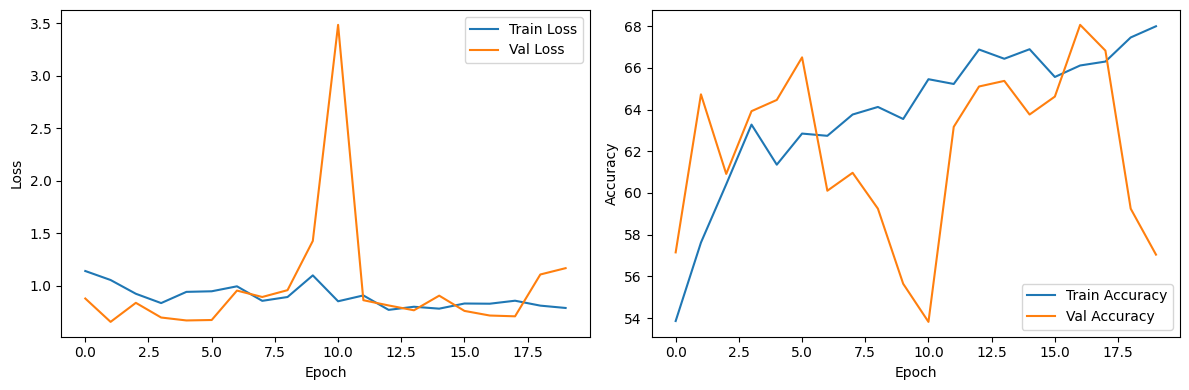

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the BERT classifier model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids, attention_mask)[1]
        logits = self.fc(output)
        return logits

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model = AlbertModel.from_pretrained("neuropark/sahajBERT")


hidden_dim = bert_model.config.hidden_size
num_classes = 2

model = BERTClassifier(bert_model, hidden_dim, num_classes).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

best_accuracy = 0.0

for param in model.bert_model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

fold_train_losses = []
fold_train_accuracies = []
fold_val_losses = []
fold_val_accuracies = []
fold_val_predictions = []
fold_val_labels = []

train_losses_per_epoch = []
train_accuracies_per_epoch = []
val_losses_per_epoch = []
val_accuracies_per_epoch = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
      input_ids, attention_mask, labels = batch
      input_ids = input_ids.to(DEVICE)
      attention_mask = attention_mask.to(DEVICE)
      labels = labels.to(DEVICE)

      optimizer.zero_grad()

      logits = model(input_ids, attention_mask)
      _, predicted = torch.max(logits, 1)

      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * input_ids.size(0)
      train_total += labels.size(0)
      train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
          input_ids, attention_mask, labels = batch
          input_ids = input_ids.to(DEVICE)
          attention_mask = attention_mask.to(DEVICE)
          labels = labels.to(DEVICE)

          logits = model(input_ids, attention_mask)
          _, predicted = torch.max(logits, 1)

          loss = criterion(logits, labels)

          val_loss += loss.item() * input_ids.size(0)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

          fold_val_predictions.extend(predicted.cpu().numpy())
          fold_val_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total

    fold_train_losses.append(train_loss / train_total)
    fold_train_accuracies.append(train_accuracy)
    fold_val_losses.append(val_loss / val_total)
    fold_val_accuracies.append(val_accuracy)

    train_losses_per_epoch.append(train_loss / train_total)
    train_accuracies_per_epoch.append(train_accuracy)
    val_losses_per_epoch.append(val_loss / val_total)
    val_accuracies_per_epoch.append(val_accuracy)

    print('Epoch: {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}% | Val Loss: {:.4f} | Val Accuracy: {:.2f}%'.format(
        epoch + 1, NUM_EPOCHS, train_loss / train_total, train_accuracy, val_loss / val_total, val_accuracy))

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

# Calculate performance metrics
average_accuracy = accuracy_score(fold_val_labels, fold_val_predictions)
average_precision = precision_score(fold_val_labels, fold_val_predictions)
average_recall = recall_score(fold_val_labels, fold_val_predictions)
average_f1_score = f1_score(fold_val_labels, fold_val_predictions)

# Print average metrics across folds
print('Average Metrics Across Folds:')
print('Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(
    average_accuracy, average_precision, average_recall, average_f1_score))

# Plotting the train and validation accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(val_losses_per_epoch, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(val_accuracies_per_epoch, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
label = ['Depressive', 'Non Depressive']

In [16]:
from sklearn.metrics import classification_report

# Define the label names
label_names = ['Non-Depressive', 'Depressive']

# Generate classification report
classification_report_output = classification_report(fold_val_labels, fold_val_predictions, target_names=label_names)

# Print the classification report
print('Classification Report for BERT Classifier:')
print(classification_report_output)


Classification Report for BERT Classifier:
                precision    recall  f1-score   support

Non-Depressive       0.62      0.60      0.61     18400
    Depressive       0.62      0.64      0.63     18800

      accuracy                           0.62     37200
     macro avg       0.62      0.62      0.62     37200
  weighted avg       0.62      0.62      0.62     37200



In [17]:
def perf_matrix(true_labels, predicted_labels):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

    # Generate performance metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print('Performance Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    return confusion_matrix(true_labels, predicted_labels)

# Call the function to display metrics
cm = perf_matrix(fold_val_labels, fold_val_predictions)


Performance Metrics:
Accuracy: 0.6203
Precision: 0.6217
Recall: 0.6355
F1 Score: 0.6285


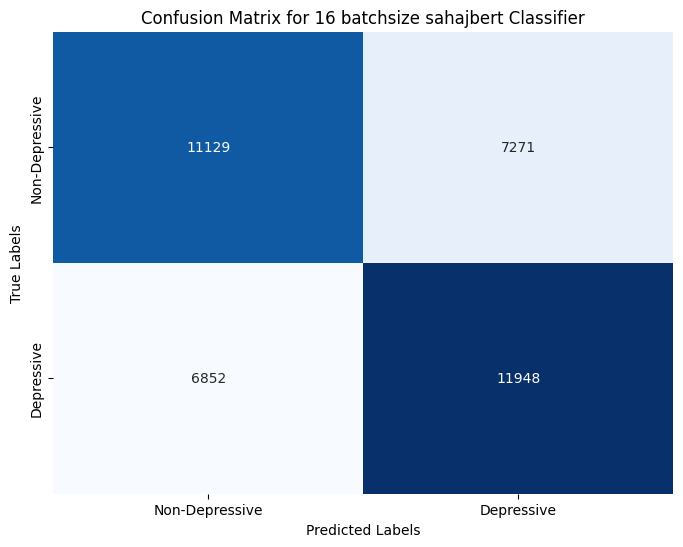

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(fold_val_labels, fold_val_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for 16 batchsize sahajbert Classifier')

# Save as PNG with 400 DPI
plt.savefig('16_sahajbert_confusion_matrix.png', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
# Define the BERT model architecture
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output['pooler_output']
        pooled_output = self.dropout(pooled_output)
        logits = self.fc(pooled_output)
        return torch.sigmoid(logits)



DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = PreTrainedTokenizerFast.from_pretrained("neuropark/sahajBERT")

X_encodings = tokenizer(list(X), truncation=True, padding=True, max_length=512)


y_tensor = torch.tensor(y.values)

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(skf.split(X_encodings['input_ids'], y_tensor), 1):
    print(f"Processing Fold: {fold}")

    X_encodings_list = list(X_encodings.items())


    X_train_fold = {key: [value[i] for i in train_index] for key, value in X_encodings_list}
    X_val_fold = {key: [value[i] for i in val_index] for key, value in X_encodings_list}
    y_train_fold = y_tensor[train_index]
    y_val_fold = y_tensor[val_index]

    train_dataset = TensorDataset(torch.tensor(X_train_fold['input_ids']),
                                  torch.tensor(X_train_fold['attention_mask']),
                                  torch.tensor(y_train_fold))
    val_dataset = TensorDataset(torch.tensor(X_val_fold['input_ids']),
                                torch.tensor(X_val_fold['attention_mask']),
                                torch.tensor(y_val_fold))

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


Processing Fold: 1


/tmp/ipykernel_29/1196739732.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train_fold))
/tmp/ipykernel_29/1196739732.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_val_fold))


Processing Fold: 2
Processing Fold: 3
Processing Fold: 4
Processing Fold: 5


In [ ]:
torch.cuda.empty_cache()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the BERT classifier model
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, hidden_dim, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert_model = bert_model
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = output.last_hidden_state[:, 0, :]
        logits = self.fc(cls_output)
        return logits

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bert_model = AlbertModel.from_pretrained("neuropark/sahajBERT")

hidden_dim = bert_model.config.hidden_size
num_classes = 2

model = BERTClassifier(bert_model, hidden_dim, num_classes).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

best_accuracy = 0.0

for param in model.bert_model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

fold_train_losses = []
fold_train_accuracies = []
fold_val_losses = []
fold_val_accuracies = []
fold_val_predictions = []
fold_val_labels = []

train_losses_per_epoch = []
train_accuracies_per_epoch = []
val_losses_per_epoch = []
val_accuracies_per_epoch = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        _, predicted = torch.max(logits, 1)

        labels = labels.squeeze()

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * input_ids.size(0)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, 1)

            loss = criterion(logits, labels)

            val_loss += loss.item() * input_ids.size(0)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            fold_val_predictions.extend(predicted.cpu().numpy())
            fold_val_labels.extend(labels.cpu().numpy())

    val_accuracy = 100 * val_correct / val_total

    fold_train_losses.append(train_loss / train_total)
    fold_train_accuracies.append(train_accuracy)
    fold_val_losses.append(val_loss / val_total)
    fold_val_accuracies.append(val_accuracy)

    train_losses_per_epoch.append(train_loss / train_total)
    train_accuracies_per_epoch.append(train_accuracy)
    val_losses_per_epoch.append(val_loss / val_total)
    val_accuracies_per_epoch.append(val_accuracy)

    print('Epoch: {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}% | Val Loss: {:.4f} | Val Accuracy: {:.2f}%'.format(
        epoch + 1, NUM_EPOCHS, train_loss / train_total, train_accuracy, val_loss / val_total, val_accuracy))

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')

average_accuracy = accuracy_score(fold_val_labels, fold_val_predictions)
average_precision = precision_score(fold_val_labels, fold_val_predictions)
average_recall = recall_score(fold_val_labels, fold_val_predictions)
average_f1_score = f1_score(fold_val_labels, fold_val_predictions)

print('Average Metrics Across Folds:')
print('Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(
    average_accuracy, average_precision, average_recall, average_f1_score))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_per_epoch, label='Train Loss')
plt.plot(val_losses_per_epoch, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_per_epoch, label='Train Accuracy')
plt.plot(val_accuracies_per_epoch, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
print('Hyperparameters:')
print('Batch Size:', BATCH_SIZE)
print('Learning Rate:', LEARNING_RATE)
print('Dropout:', DROPOUT)
print('Number of Epochs:', NUM_EPOCHS)
print('Number of Folds:', NUM_FOLDS)
print('Momentum:', MOMENTUM)

print('Average Metrics Across Folds:')
print('Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(
    average_accuracy, average_precision, average_recall, average_f1_score))